In [1]:
# Cell 1: Setup (repo root + strict repo-local R library)
source("../setup/r_bootstrap.R")

Repo root: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea 
No issues found -- the project is in a consistent state.
renv is synchronized.
✅ R bootstrap complete.


In [2]:
# Cell 2: Load all required libraries and data

suppressPackageStartupMessages({
  library(ggplot2)
  library(dplyr)
  library(ggrepel)
  library(ComplexHeatmap)
  library(circlize)
  library(grid)
  library(cluster)
  library(survival)
  library(survminer)
  library(fgsea)
  library(knitr)
  library(stringr)
  library(data.table)
})

# ========================
# Define paths
# ========================
deg_fp    <- file.path(REPO_ROOT, "results/tables/deg", "DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma.csv")
fgsea_fp  <- file.path(REPO_ROOT, "results/tables/gsea", "fgsea_results_all_databases.csv")
expr_fp   <- file.path(REPO_ROOT, "data/processed/preprocessing_outputs", "expr_LumA_IDC_Tumor_vs_AllNormals.tsv")
meta_fp   <- file.path(REPO_ROOT, "data/processed/preprocessing_outputs", "metadata_LumA_IDC_Tumor_vs_AllNormals.tsv")

stopifnot(file.exists(deg_fp), file.exists(expr_fp), file.exists(meta_fp))

# Output directories
deg_fig_dir  <- file.path(REPO_ROOT, "results/figures/deg")
gsea_fig_dir <- file.path(REPO_ROOT, "results/figures/gsea")
clin_fig_dir <- file.path(REPO_ROOT, "results/figures/clinical")
dir.create(deg_fig_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(gsea_fig_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(clin_fig_dir, recursive = TRUE, showWarnings = FALSE)

# ========================
# Load data
# ========================
# DEG results
deg <- read.csv(deg_fp, stringsAsFactors = FALSE)
cat("DEG table loaded:", nrow(deg), "genes\n")

# fgsea results (if available)
if (file.exists(fgsea_fp)) {
  fgsea_all <- read.csv(fgsea_fp, stringsAsFactors = FALSE)
  cat("fgsea results loaded:", nrow(fgsea_all), "pathways\n")
} else {
  cat("fgsea results not found - run notebook 02 first\n")
  fgsea_all <- NULL
}

# Expression matrix
expr_dt <- fread(expr_fp)
gene <- expr_dt[[1]]
expr <- as.matrix(expr_dt[, -1, with = FALSE])
rownames(expr) <- gene
cat("Expression:", nrow(expr), "x", ncol(expr), "\n")

# Metadata (with extended clinical info)
meta <- read.delim(meta_fp, stringsAsFactors = FALSE, check.names = FALSE)
cat("Metadata:", nrow(meta), "x", ncol(meta), "\n")
cat("Columns:", paste(colnames(meta), collapse = ", "), "\n")
print(table(meta$Group))

# Align metadata to expression columns
meta <- meta[match(colnames(expr), meta$Sample), ]
stopifnot(all(meta$Sample == colnames(expr)))

DEG table loaded: 20530 genes
fgsea results loaded: 5348 pathways
Expression: 20530 x 413 
Metadata: 413 x 16 
Columns: Sample, Group, molecular_subtype, sample_type, histological_type, OS_time, OS_event, ER_status, PR_status, HER2_status, stage, T_stage, N_stage, age_at_diagnosis, integrated_cluster, tcga_sample_code 

Normal  Tumor 
   114    299 


In [3]:
# Cell 3: Annotate DEG Table

# Thresholds
padj_cutoff <- 0.05
log2fc_cutoff <- 1

# Annotate: -log10(padj) and regulation class
deg$negLog10Padj <- -log10(deg$padj)

deg$Regulation <- "Not Significant"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange >  log2fc_cutoff] <- "Up"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange < -log2fc_cutoff] <- "Down"

deg$Regulation <- factor(deg$Regulation, levels = c("Down","Not Significant","Up"))

cat("DE gene counts (padj <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Save annotated DEG table
annot_fp <- file.path(REPO_ROOT, "results/tables/deg", "DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma_annotated.csv")
write.csv(deg, annot_fp, row.names = FALSE)
cat("Annotated DEG table written to:\n  ", annot_fp, "\n")

DE gene counts (padj < 0.05 , |log2FC| > 1 ):

           Down Not Significant              Up 
           2770           16339            1421 
Annotated DEG table written to:
   /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/tables/deg/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma_annotated.csv 


DE gene counts (FDR < 0.05 , |log2FC| > 1 ):

           Down Not Significant              Up 
           2770           16339            1421 
Saved volcano plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/deg/Volcano_LumA_IDC_Tumor_vs_AllNormals.png 


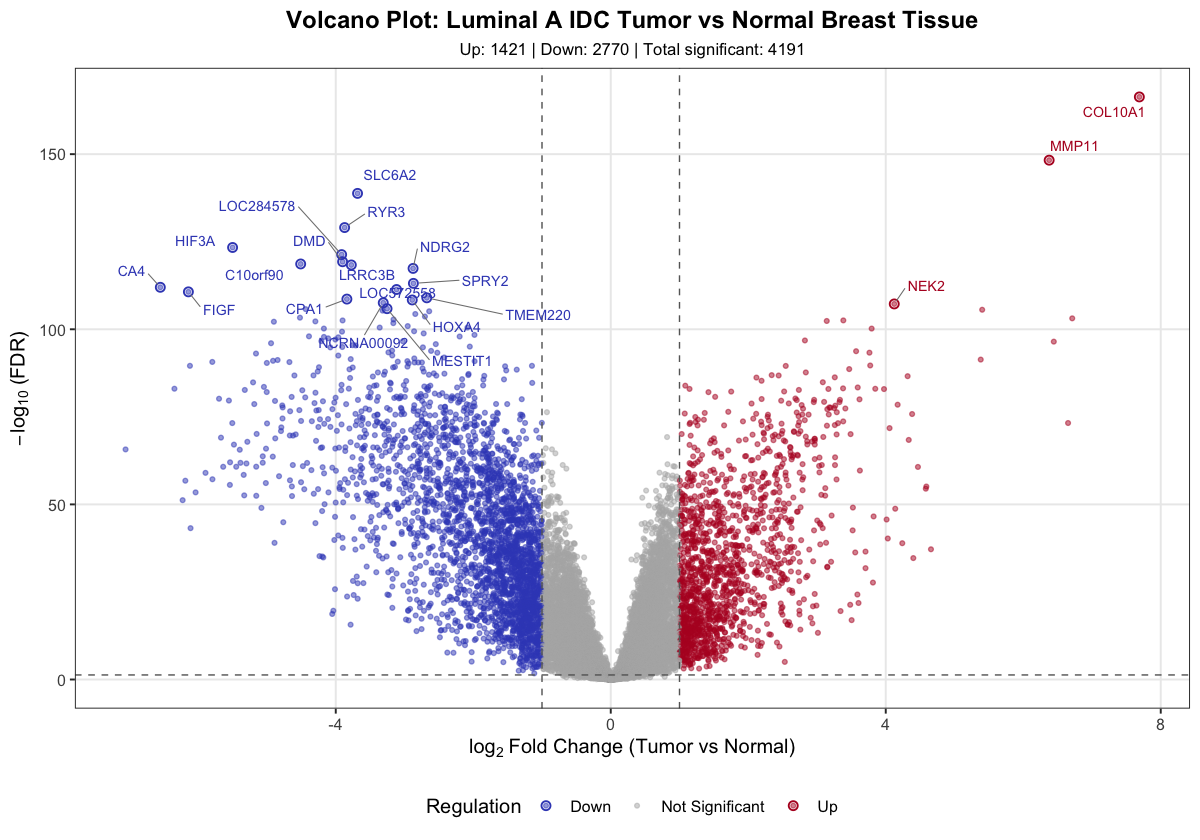

In [4]:
# Cell 4: Enhanced Volcano Plot with ggrepel

# Thresholds
padj_cutoff   <- 0.05
log2fc_cutoff <- 1

# Annotate DEG table
deg <- deg %>%
  mutate(
    negLog10Padj = -log10(padj),
    Regulation = case_when(
      padj < padj_cutoff & log2FoldChange > log2fc_cutoff ~ "Up",
      padj < padj_cutoff & log2FoldChange < -log2fc_cutoff ~ "Down",
      TRUE ~ "Not Significant"
    ),
    Regulation = factor(Regulation, levels = c("Down", "Not Significant", "Up"))
  )

cat("DE gene counts (FDR <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Select top genes to label (by significance, then by fold change)
n_label <- 20
top_genes <- deg %>%
  filter(Regulation != "Not Significant") %>%
  arrange(padj) %>%
  head(n_label)

# Build enhanced volcano plot
volcano_colors <- c("Down" = "#3B4CC0", "Not Significant" = "grey70", "Up" = "#B40426")

p_volcano <- ggplot(deg, aes(x = log2FoldChange, y = negLog10Padj, color = Regulation)) +
  geom_point(alpha = 0.5, size = 1) +
  geom_vline(xintercept = c(-log2fc_cutoff, log2fc_cutoff), linetype = "dashed", color = "grey40", linewidth = 0.4) +
  geom_hline(yintercept = -log10(padj_cutoff), linetype = "dashed", color = "grey40", linewidth = 0.4) +
  geom_point(data = top_genes, aes(x = log2FoldChange, y = negLog10Padj), size = 2, shape = 21, fill = NA, stroke = 0.8) +
  geom_text_repel(
    data = top_genes,
    aes(label = gene),
    size = 3,
    max.overlaps = 30,
    box.padding = 0.5,
    point.padding = 0.3,
    segment.color = "grey50",
    segment.size = 0.3,
    show.legend = FALSE
  ) +
  scale_color_manual(values = volcano_colors) +
  labs(
    title = "Volcano Plot: Luminal A IDC Tumor vs Normal Breast Tissue",
    subtitle = paste0("Up: ", sum(deg$Regulation == "Up"), " | Down: ", sum(deg$Regulation == "Down"), " | Total significant: ", sum(deg$Regulation != "Not Significant")),
    x = expression(log[2]~"Fold Change (Tumor vs Normal)"),
    y = expression(-log[10]~"(FDR)"),
    color = "Regulation"
  ) +
  theme_bw(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 10),
    panel.grid.minor = element_blank(),
    legend.position = "bottom"
  )

volcano_png <- file.path(deg_fig_dir, "Volcano_LumA_IDC_Tumor_vs_AllNormals.png")
ggsave(volcano_png, p_volcano, width = 10, height = 7, dpi = 300)
cat("Saved volcano plot:", volcano_png, "\n")

options(repr.plot.width = 10, repr.plot.height = 7)
print(p_volcano)

Saved Hallmark dot plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/gsea/fgsea_Hallmark_dotplot.png 
Saved KEGG dot plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/gsea/fgsea_KEGG_dotplot.png 


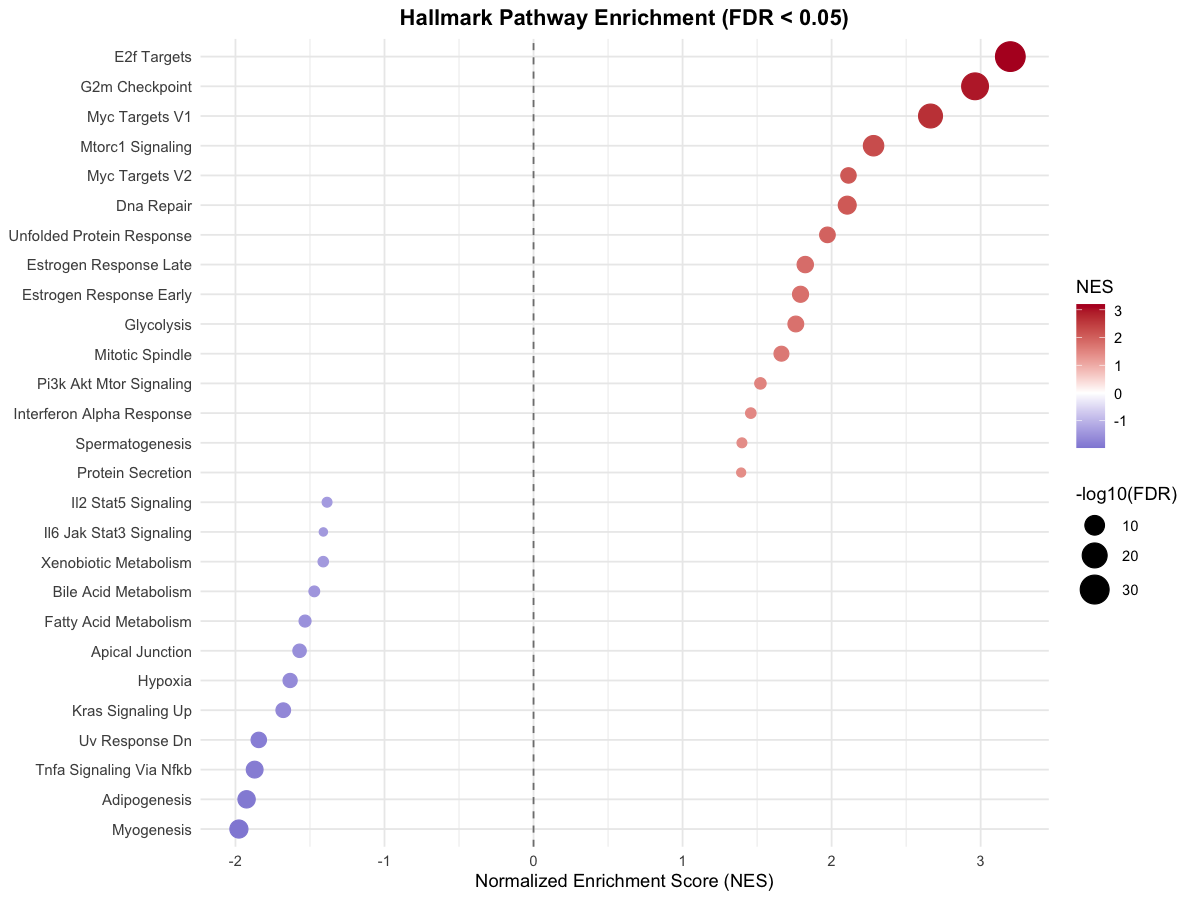


fgsea visualization complete.


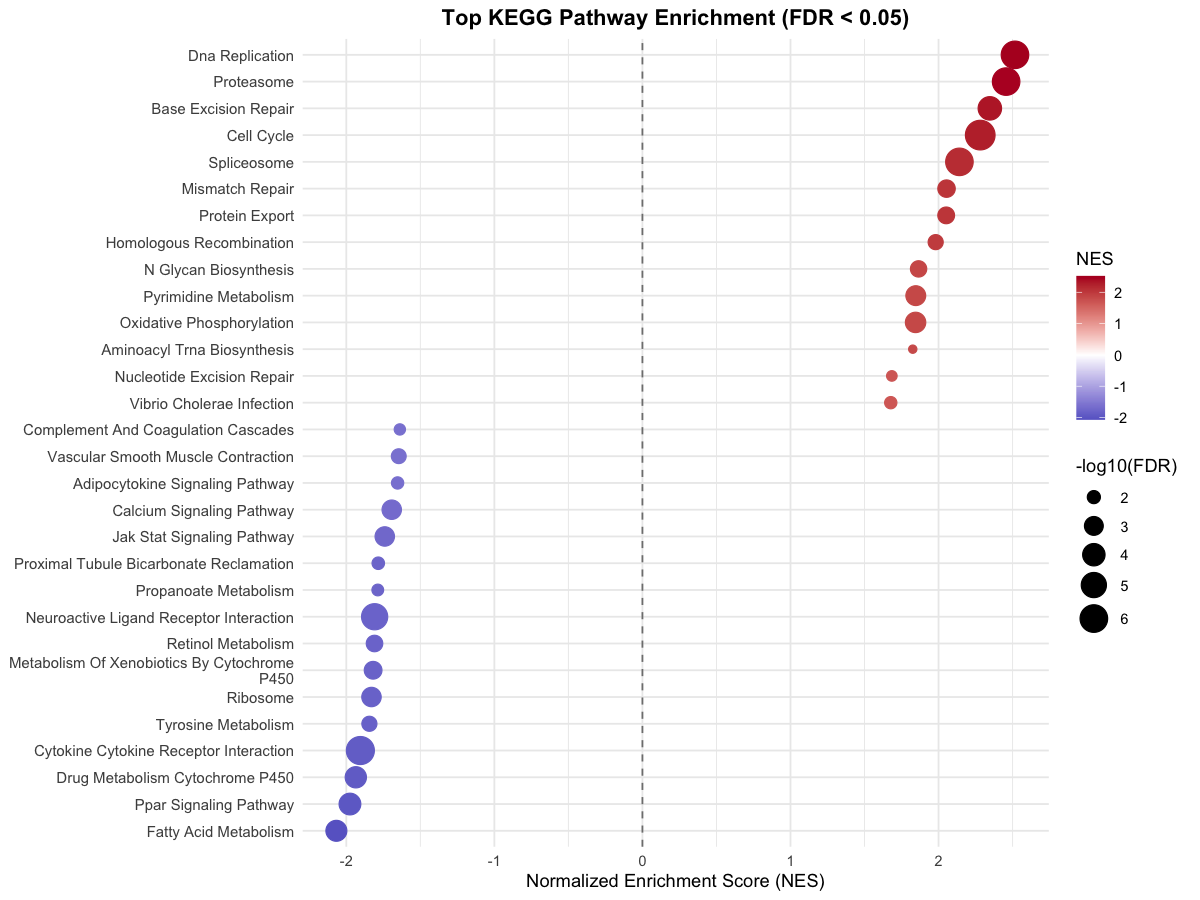

In [5]:
# Cell 5: fgsea Visualization - Dot plots and enrichment curves

if (!is.null(fgsea_all)) {
  
  # Clean pathway names for display
  clean_pathway <- function(x) {
    x <- gsub("^HALLMARK_", "", x)
    x <- gsub("^KEGG_", "", x)
    x <- gsub("^REACTOME_", "", x)
    x <- gsub("^GOBP_", "", x)
    x <- gsub("_", " ", x)
    x <- str_to_title(x)
    str_wrap(x, width = 40)
  }
  
  # ========================
  # Hallmark dot plot
  # ========================
  fgsea_hallmark <- fgsea_all %>%
    filter(Database == "Hallmark", padj < 0.05) %>%
    arrange(NES) %>%
    mutate(
      pathway_clean = clean_pathway(pathway),
      pathway_clean = factor(pathway_clean, levels = pathway_clean)
    )
  
  if (nrow(fgsea_hallmark) > 0) {
    p_hallmark <- ggplot(fgsea_hallmark, aes(x = NES, y = pathway_clean)) +
      geom_point(aes(size = -log10(padj), color = NES)) +
      geom_vline(xintercept = 0, linetype = "dashed", color = "grey50") +
      scale_color_gradient2(low = "#3B4CC0", mid = "white", high = "#B40426", midpoint = 0) +
      scale_size_continuous(range = c(2, 8), name = "-log10(FDR)") +
      labs(
        title = "Hallmark Pathway Enrichment (FDR < 0.05)",
        x = "Normalized Enrichment Score (NES)",
        y = NULL,
        color = "NES"
      ) +
      theme_minimal(base_size = 11) +
      theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.y = element_text(size = 9)
      )
    
    hallmark_png <- file.path(gsea_fig_dir, "fgsea_Hallmark_dotplot.png")
    ggsave(hallmark_png, p_hallmark, width = 10, height = max(6, nrow(fgsea_hallmark) * 0.25), dpi = 300)
    cat("Saved Hallmark dot plot:", hallmark_png, "\n")
    
    options(repr.plot.width = 10, repr.plot.height = max(6, nrow(fgsea_hallmark) * 0.25))
    print(p_hallmark)
  }
  
  # ========================
  # KEGG dot plot (top 30)
  # ========================
  fgsea_kegg <- fgsea_all %>%
    filter(Database == "KEGG", padj < 0.05) %>%
    arrange(desc(abs(NES))) %>%
    head(30) %>%
    arrange(NES) %>%
    mutate(
      pathway_clean = clean_pathway(pathway),
      pathway_clean = factor(pathway_clean, levels = pathway_clean)
    )
  
  if (nrow(fgsea_kegg) > 0) {
    p_kegg <- ggplot(fgsea_kegg, aes(x = NES, y = pathway_clean)) +
      geom_point(aes(size = -log10(padj), color = NES)) +
      geom_vline(xintercept = 0, linetype = "dashed", color = "grey50") +
      scale_color_gradient2(low = "#3B4CC0", mid = "white", high = "#B40426", midpoint = 0) +
      scale_size_continuous(range = c(2, 8), name = "-log10(FDR)") +
      labs(
        title = "Top KEGG Pathway Enrichment (FDR < 0.05)",
        x = "Normalized Enrichment Score (NES)",
        y = NULL,
        color = "NES"
      ) +
      theme_minimal(base_size = 11) +
      theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.y = element_text(size = 9)
      )
    
    kegg_png <- file.path(gsea_fig_dir, "fgsea_KEGG_dotplot.png")
    ggsave(kegg_png, p_kegg, width = 10, height = max(6, nrow(fgsea_kegg) * 0.25), dpi = 300)
    cat("Saved KEGG dot plot:", kegg_png, "\n")
    
    options(repr.plot.width = 10, repr.plot.height = max(6, nrow(fgsea_kegg) * 0.25))
    print(p_kegg)
  }
  
  cat("\nfgsea visualization complete.\n")
} else {
  cat("Skipping fgsea visualization - results not available.\n")
}

In [ ]:
# Cell 6: Exploratory Analysis - Tumor Heterogeneity Scoring

# ============================================================================
# GOAL: Quantify how much each tumor deviates from the "expected" pattern
# For genes DOWN-regulated in tumors: high expression = more "normal-like"
# For genes UP-regulated in tumors: low expression = more "normal-like"
# ============================================================================

tumor_samples <- meta$Sample[meta$Group == "Tumor"]
normal_samples <- meta$Sample[meta$Group == "Normal"]

cat("Tumor samples:", length(tumor_samples), "\n")
cat("Normal samples:", length(normal_samples), "\n\n")

# Get significant DEGs
deg_down <- deg %>% filter(Regulation == "Down") %>% arrange(padj) %>% head(50)
deg_up <- deg %>% filter(Regulation == "Up") %>% arrange(padj) %>% head(50)

down_genes <- deg_down$gene[deg_down$gene %in% rownames(expr)]
up_genes <- deg_up$gene[deg_up$gene %in% rownames(expr)]

cat("Using top", length(down_genes), "down-regulated genes\n")
cat("Using top", length(up_genes), "up-regulated genes\n\n")

# ============================================================================
# Calculate reference: mean expression in NORMAL samples
# ============================================================================
normal_mean_down <- rowMeans(expr[down_genes, normal_samples])
normal_mean_up <- rowMeans(expr[up_genes, normal_samples])

# ============================================================================
# For each TUMOR sample, calculate deviation scores
# ============================================================================
tumor_scores <- data.frame(Sample = tumor_samples)

# Score 1: Mean expression of DOWN genes (higher = more normal-like)
tumor_scores$down_genes_expr <- sapply(tumor_samples, function(s) {
  mean(expr[down_genes, s])
})

# Score 2: Mean expression of UP genes (lower = more normal-like)
tumor_scores$up_genes_expr <- sapply(tumor_samples, function(s) {
  mean(expr[up_genes, s])
})

# Score 3: Correlation with normal profile for DOWN genes
tumor_scores$down_genes_cor_normal <- sapply(tumor_samples, function(s) {
  cor(expr[down_genes, s], normal_mean_down, use = "complete.obs")
})

# Score 4: Correlation with normal profile for UP genes  
tumor_scores$up_genes_cor_normal <- sapply(tumor_samples, function(s) {
  cor(expr[up_genes, s], normal_mean_up, use = "complete.obs")
})

# Score 5: "Discordance" - how many DOWN genes are actually HIGH in this tumor?
# (above the median tumor expression for that gene)
tumor_median_down <- apply(expr[down_genes, tumor_samples], 1, median)
tumor_scores$pct_down_genes_high <- sapply(tumor_samples, function(s) {
  sum(expr[down_genes, s] > tumor_median_down) / length(down_genes) * 100
})

# ============================================================================
# Visualize the heterogeneity
# ============================================================================

# Plot 1: Distribution of DOWN gene expression across tumors
p1 <- ggplot(tumor_scores, aes(x = down_genes_expr)) +
  geom_histogram(bins = 30, fill = "steelblue", alpha = 0.7, color = "white") +
  geom_vline(xintercept = mean(normal_mean_down), color = "green", linetype = "dashed", linewidth = 1) +
  annotate("text", x = mean(normal_mean_down), y = Inf, label = "Normal mean", 
           vjust = 2, hjust = -0.1, color = "darkgreen") +
  labs(
    title = "Distribution: Expression of DOWN-regulated Genes in Tumors",
    subtitle = "Higher values = more 'normal-like' expression",
    x = "Mean Expression of Top 50 Down-regulated Genes",
    y = "Number of Tumors"
  ) +
  theme_bw(base_size = 12) +
  theme(plot.title = element_text(face = "bold"))

# Plot 2: % of DOWN genes with high expression per tumor
p2 <- ggplot(tumor_scores, aes(x = pct_down_genes_high)) +
  geom_histogram(bins = 30, fill = "coral", alpha = 0.7, color = "white") +
  labs(
    title = "Discordance: % of DOWN Genes with HIGH Expression",
    subtitle = "Higher % = more genes deviating from expected pattern",
    x = "% of Down-regulated Genes Showing High Expression",
    y = "Number of Tumors"
  ) +
  theme_bw(base_size = 12) +
  theme(plot.title = element_text(face = "bold"))

# Plot 3: Scatter - DOWN vs UP gene expression
p3 <- ggplot(tumor_scores, aes(x = down_genes_expr, y = up_genes_expr)) +
  geom_point(alpha = 0.6, size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(
    title = "DOWN vs UP Gene Expression Across Tumors",
    subtitle = paste("Correlation:", round(cor(tumor_scores$down_genes_expr, 
                                                tumor_scores$up_genes_expr), 3)),
    x = "Mean Expression of DOWN Genes",
    y = "Mean Expression of UP Genes"
  ) +
  theme_bw(base_size = 12) +
  theme(plot.title = element_text(face = "bold"))

# Save plots
ggsave(file.path(clin_fig_dir, "tumor_heterogeneity_down_genes_dist.png"), p1, width = 8, height = 5, dpi = 300)
ggsave(file.path(clin_fig_dir, "tumor_heterogeneity_discordance.png"), p2, width = 8, height = 5, dpi = 300)
ggsave(file.path(clin_fig_dir, "tumor_heterogeneity_down_vs_up.png"), p3, width = 7, height = 6, dpi = 300)

print(p1)
print(p2)
print(p3)

# ============================================================================
# Create categorical groups based on DOWN gene expression (for downstream analysis)
# Using tertiles as a reasonable exploratory split
# ============================================================================
tumor_scores$down_expr_tertile <- cut(tumor_scores$down_genes_expr,
                                       breaks = quantile(tumor_scores$down_genes_expr, c(0, 1/3, 2/3, 1)),
                                       labels = c("Low", "Mid", "High"),
                                       include.lowest = TRUE)

cat("\n=== Tumor Tertiles by DOWN Gene Expression ===\n")
cat("(High = more normal-like expression of typically down-regulated genes)\n\n")
print(table(tumor_scores$down_expr_tertile))

# Add to metadata
meta$down_expr_tertile <- NA
meta$down_expr_tertile[match(tumor_scores$Sample, meta$Sample)] <- as.character(tumor_scores$down_expr_tertile)
meta$down_expr_tertile[meta$Group == "Normal"] <- "Normal"
meta$down_expr_tertile <- factor(meta$down_expr_tertile, levels = c("Normal", "Low", "Mid", "High"))

# Also add continuous scores
meta$down_genes_expr <- NA
meta$down_genes_expr[match(tumor_scores$Sample, meta$Sample)] <- tumor_scores$down_genes_expr
meta$pct_discordant <- NA
meta$pct_discordant[match(tumor_scores$Sample, meta$Sample)] <- tumor_scores$pct_down_genes_high

# For backward compatibility with heatmap code
meta$Cluster <- meta$down_expr_tertile

# Summary statistics
cat("\n=== Summary Statistics by Tertile ===\n")
print(tumor_scores %>% 
  group_by(down_expr_tertile) %>% 
  summarise(
    n = n(),
    mean_down_expr = round(mean(down_genes_expr), 2),
    mean_pct_discordant = round(mean(pct_down_genes_high), 1),
    mean_cor_normal = round(mean(down_genes_cor_normal), 3)
  ))

# Save scores
scores_fp <- file.path(REPO_ROOT, "results/tables/deg", "tumor_heterogeneity_scores.csv")
write.csv(tumor_scores, scores_fp, row.names = FALSE)
cat("\nSaved tumor scores:", scores_fp, "\n")

In [ ]:
# Cell 7: Clinical Correlation Analysis (Tumor Clusters)

# Check what clinical variables are available
clinical_vars <- c("OS_time", "OS_event", "ER_status", "PR_status", "HER2_status", 
                   "stage", "T_stage", "N_stage", "age_at_diagnosis")
available_vars <- intersect(clinical_vars, colnames(meta))
cat("Available clinical variables:", paste(available_vars, collapse = ", "), "\n\n")

# Focus on tumor samples only for clinical analysis
meta_tumor <- meta %>% filter(Group == "Tumor")
cat("Tumor samples for clinical analysis:", nrow(meta_tumor), "\n")
cat("Tumor clusters:", paste(sort(unique(meta_tumor$Cluster)), collapse = ", "), "\n\n")

# ========================
# Survival Analysis (if data available)
# ========================
if (all(c("OS_time", "OS_event") %in% colnames(meta_tumor))) {
  
  # Clean survival data
  surv_data <- meta_tumor %>%
    filter(!is.na(OS_time), !is.na(OS_event)) %>%
    mutate(
      OS_time = as.numeric(OS_time),
      OS_event = as.numeric(OS_event)
    ) %>%
    filter(!is.na(OS_time), !is.na(OS_event))
  
  cat("Samples with survival data:", nrow(surv_data), "\n")
  
  if (nrow(surv_data) > 20 && length(unique(surv_data$Cluster)) > 1) {
    # Kaplan-Meier by cluster
    fit <- survfit(Surv(OS_time, OS_event) ~ Cluster, data = surv_data)
    
    p_surv <- ggsurvplot(
      fit,
      data = surv_data,
      pval = TRUE,
      pval.method = TRUE,
      risk.table = TRUE,
      risk.table.col = "strata",
      ggtheme = theme_bw(base_size = 12),
      palette = "jco",
      title = "Overall Survival by Tumor Expression Cluster",
      xlab = "Time (days)",
      ylab = "Survival Probability"
    )
    
    surv_png <- file.path(clin_fig_dir, "survival_by_tumor_cluster.png")
    ggsave(surv_png, print(p_surv), width = 10, height = 8, dpi = 300)
    cat("Saved survival plot:", surv_png, "\n")
    print(p_surv)
  } else {
    cat("Insufficient survival data or single cluster - skipping survival analysis\n")
  }
} else {
  cat("Survival data not available in metadata\n")
}

# ========================
# Clinical Variable Associations with Tumor Clusters
# ========================
cat("\n\n=== Clinical Variable Associations with Tumor Clusters ===\n\n")

# Categorical variables - Chi-squared tests
cat_vars <- c("ER_status", "PR_status", "HER2_status", "stage")
cat_vars <- intersect(cat_vars, colnames(meta_tumor))

for (var in cat_vars) {
  var_data <- meta_tumor[[var]]
  if (!is.null(var_data) && sum(!is.na(var_data)) > 10) {
    cat(paste0("\n--- ", var, " ---\n"))
    tbl <- table(meta_tumor$Cluster, var_data, useNA = "no")
    if (nrow(tbl) > 1 && ncol(tbl) > 1) {
      print(tbl)
      
      # Chi-squared or Fisher's exact test
      if (min(tbl) < 5 || any(dim(tbl) < 2)) {
        test <- fisher.test(tbl, simulate.p.value = TRUE)
        cat("Fisher's exact test p-value:", formatC(test$p.value, format = "e", digits = 2), "\n")
      } else {
        test <- chisq.test(tbl)
        cat("Chi-squared test p-value:", formatC(test$p.value, format = "e", digits = 2), "\n")
      }
    }
  }
}

# Continuous variables - ANOVA
if ("age_at_diagnosis" %in% colnames(meta_tumor)) {
  age_data <- meta_tumor %>%
    filter(!is.na(age_at_diagnosis)) %>%
    mutate(age_at_diagnosis = as.numeric(age_at_diagnosis)) %>%
    filter(!is.na(age_at_diagnosis))
  
  if (nrow(age_data) > 10 && length(unique(age_data$Cluster)) > 1) {
    cat("\n--- Age at Diagnosis ---\n")
    cat("Mean age by tumor cluster:\n")
    print(age_data %>% group_by(Cluster) %>% summarise(
      n = n(),
      mean_age = round(mean(age_at_diagnosis, na.rm = TRUE), 1),
      sd_age = round(sd(age_at_diagnosis, na.rm = TRUE), 1)
    ))
    
    aov_result <- aov(age_at_diagnosis ~ Cluster, data = age_data)
    cat("ANOVA p-value:", formatC(summary(aov_result)[[1]][["Pr(>F)"]][1], format = "e", digits = 2), "\n")
    
    # Box plot
    p_age <- ggplot(age_data, aes(x = Cluster, y = age_at_diagnosis, fill = Cluster)) +
      geom_boxplot(alpha = 0.7) +
      geom_jitter(width = 0.2, alpha = 0.3, size = 1) +
      labs(
        title = "Age at Diagnosis by Tumor Cluster",
        x = "Cluster",
        y = "Age (years)"
      ) +
      theme_bw(base_size = 12) +
      theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "none"
      )
    
    age_png <- file.path(clin_fig_dir, "age_by_tumor_cluster.png")
    ggsave(age_png, p_age, width = 7, height = 5, dpi = 300)
    cat("Saved age plot:", age_png, "\n")
    print(p_age)
  }
}

In [ ]:
# Cell 8: Heatmap - Ordered by UP Gene Expression

# ========================
# Prepare expression data for heatmap
# ========================
deg_up <- deg %>% filter(Regulation == "Up") %>% arrange(padj) %>% head(25)
deg_down <- deg %>% filter(Regulation == "Down") %>% arrange(padj) %>% head(25)
genes_top <- unique(c(deg_up$gene, deg_down$gene))
genes_top <- genes_top[genes_top %in% rownames(expr)]

cat("Heatmap includes", length(genes_top), "genes\n")

# Subset and scale expression
expr_sub <- expr[genes_top, , drop = FALSE]
expr_scaled <- t(scale(t(expr_sub)))
expr_scaled[is.na(expr_scaled)] <- 0

# ========================
# Calculate UP gene expression score for ordering
# ========================
up_genes <- deg_up$gene[deg_up$gene %in% rownames(expr)]

tumor_scores$up_genes_mean <- sapply(tumor_scores$Sample, function(s) {
  mean(expr[up_genes, s])
})

# ========================
# ORDER SAMPLES by UP gene expression (high to low = most tumor-like to least)
# ========================
tumor_scores_ordered <- tumor_scores[order(tumor_scores$up_genes_mean, decreasing = TRUE), ]
tumor_order <- tumor_scores_ordered$Sample

normal_order <- meta$Sample[meta$Group == "Normal"]
sample_order <- c(tumor_order, normal_order)
expr_scaled <- expr_scaled[, sample_order]

# Align metadata to new order
meta_sub <- meta[match(colnames(expr_scaled), meta$Sample), ]
rownames(meta_sub) <- meta_sub$Sample

# Add UP gene score to meta_sub
meta_sub$up_genes_mean <- NA
meta_sub$up_genes_mean[match(tumor_scores$Sample, meta_sub$Sample)] <- tumor_scores$up_genes_mean

cat("Samples ordered: Tumors (high→low UP gene expr) → Normals\n\n")

# ========================
# Define colors
# ========================
TUMOR_COLOR  <- "#FFC300"
NORMAL_COLOR <- "#1B9E77"
UP_COLOR     <- "#B40426"
DOWN_COLOR   <- "#3B4CC0"

# Tertile colors
tertile_colors <- c("Normal" = NORMAL_COLOR, "Low" = "#d73027", "Mid" = "#fee08b", "High" = "#1a9850")

# ========================
# Column annotations (samples)
# ========================
ha_col <- HeatmapAnnotation(
  Group = meta_sub$Group,
  `DOWN Tertile` = meta_sub$down_expr_tertile,
  `UP Gene Expr` = anno_barplot(
    ifelse(is.na(meta_sub$up_genes_mean), 0, meta_sub$up_genes_mean),
    height = unit(15, "mm"),
    gp = gpar(fill = ifelse(meta_sub$Group == "Normal", NORMAL_COLOR, UP_COLOR)),
    ylim = c(min(meta_sub$up_genes_mean, na.rm = TRUE) - 0.5, 
             max(meta_sub$up_genes_mean, na.rm = TRUE) + 0.5)
  ),
  col = list(
    Group = c("Tumor" = TUMOR_COLOR, "Normal" = NORMAL_COLOR),
    `DOWN Tertile` = tertile_colors
  ),
  annotation_legend_param = list(
    Group = list(title = "Sample Type", title_gp = gpar(fontface = "bold")),
    `DOWN Tertile` = list(title = "DOWN Gene\nExpression", title_gp = gpar(fontface = "bold"))
  ),
  gap = unit(2, "mm"),
  annotation_name_gp = gpar(fontsize = 9)
)

# ========================
# Row annotations (genes)
# ========================
row_reg <- ifelse(rownames(expr_scaled) %in% deg_up$gene, "Up", "Down")
ha_row <- rowAnnotation(
  Regulation = row_reg,
  col = list(Regulation = c("Up" = UP_COLOR, "Down" = DOWN_COLOR)),
  annotation_legend_param = list(
    Regulation = list(title = "DEG Direction", title_gp = gpar(fontface = "bold"))
  )
)

# ========================
# Build heatmap - NO column clustering (preserve our order)
# ========================
EXPR_COLORS <- colorRamp2(c(-3, 0, 3), c("blue", "white", "red"))

h <- Heatmap(
  expr_scaled,
  name = "Z-score",
  col = EXPR_COLORS,
  top_annotation = ha_col,
  left_annotation = ha_row,
  show_row_names = TRUE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  row_names_gp = gpar(fontsize = 8),
  column_title = "Top 50 DEGs: Tumors Ordered by UP Gene Expression (High → Low) | Normals",
  column_title_gp = gpar(fontsize = 12, fontface = "bold"),
  heatmap_legend_param = list(
    title = "Z-score",
    title_gp = gpar(fontface = "bold"),
    at = c(-3, 0, 3),
    legend_height = unit(4, "cm")
  ),
  row_dend_width = unit(20, "mm"),
  column_split = factor(meta_sub$Group, levels = c("Tumor", "Normal")),
  column_gap = unit(3, "mm")
)

# ========================
# Save heatmap
# ========================
heatmap_png <- file.path(deg_fig_dir, "Top50_DEGs_Heatmap_ordered_by_UP.png")
heatmap_pdf <- file.path(deg_fig_dir, "Top50_DEGs_Heatmap_ordered_by_UP.pdf")

png(heatmap_png, width = 2400, height = 2000, res = 200)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

pdf(heatmap_pdf, width = 14, height = 12)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

cat("Saved heatmap (ordered by UP genes):\n  ", heatmap_png, "\n  ", heatmap_pdf, "\n")

# Display in notebook
options(repr.plot.width = 14, repr.plot.height = 12)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")

In [ ]:
# Cell 8b: Heatmap - Ordered by DOWN Gene Expression
# Compare with Cell 8 to see how UP and DOWN gene programs are partially independent

# ========================
# ORDER SAMPLES by DOWN gene expression (high to low = most normal-like to least)
# ========================
tumor_scores_down_ordered <- tumor_scores[order(tumor_scores$down_genes_expr, decreasing = TRUE), ]
tumor_order_down <- tumor_scores_down_ordered$Sample

# Build sample order: tumors ordered by DOWN expr, then normals
sample_order_down <- c(tumor_order_down, normal_samples)

# Resubset expression for this ordering
expr_scaled_down <- t(scale(t(expr_sub)))
expr_scaled_down[is.na(expr_scaled_down)] <- 0
expr_scaled_down <- expr_scaled_down[, sample_order_down]

# Align metadata
meta_sub_down <- meta[match(colnames(expr_scaled_down), meta$Sample), ]
rownames(meta_sub_down) <- meta_sub_down$Sample

# Add scores to meta_sub_down
meta_sub_down$down_genes_expr_score <- NA
meta_sub_down$down_genes_expr_score[match(tumor_scores$Sample, meta_sub_down$Sample)] <- tumor_scores$down_genes_expr

cat("Samples ordered: Tumors (high→low DOWN gene expr = normal-like→less normal-like) → Normals\n\n")

# ========================
# Column annotations
# ========================
ha_col_down <- HeatmapAnnotation(
  Group = meta_sub_down$Group,
  `DOWN Gene Expr` = anno_barplot(
    ifelse(is.na(meta_sub_down$down_genes_expr_score), 
           mean(tumor_scores$down_genes_expr), 
           meta_sub_down$down_genes_expr_score),
    height = unit(15, "mm"),
    gp = gpar(fill = ifelse(meta_sub_down$Group == "Normal", NORMAL_COLOR, DOWN_COLOR)),
    ylim = c(min(tumor_scores$down_genes_expr) - 0.5, 
             max(tumor_scores$down_genes_expr) + 0.5)
  ),
  col = list(
    Group = c("Tumor" = TUMOR_COLOR, "Normal" = NORMAL_COLOR)
  ),
  annotation_legend_param = list(
    Group = list(title = "Sample Type", title_gp = gpar(fontface = "bold"))
  ),
  gap = unit(2, "mm"),
  annotation_name_gp = gpar(fontsize = 9)
)

# ========================
# Build heatmap
# ========================
h_down <- Heatmap(
  expr_scaled_down,
  name = "Z-score",
  col = EXPR_COLORS,
  top_annotation = ha_col_down,
  left_annotation = ha_row,
  show_row_names = TRUE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  row_names_gp = gpar(fontsize = 8),
  column_title = "Top 50 DEGs: Tumors Ordered by DOWN Gene Expression (High → Low) | Normals",
  column_title_gp = gpar(fontsize = 12, fontface = "bold"),
  heatmap_legend_param = list(
    title = "Z-score",
    title_gp = gpar(fontface = "bold"),
    at = c(-3, 0, 3),
    legend_height = unit(4, "cm")
  ),
  row_dend_width = unit(20, "mm"),
  column_split = factor(meta_sub_down$Group, levels = c("Tumor", "Normal")),
  column_gap = unit(3, "mm")
)

# ========================
# Save heatmap
# ========================
heatmap_down_png <- file.path(deg_fig_dir, "Top50_DEGs_Heatmap_ordered_by_DOWN.png")
heatmap_down_pdf <- file.path(deg_fig_dir, "Top50_DEGs_Heatmap_ordered_by_DOWN.pdf")

png(heatmap_down_png, width = 2400, height = 2000, res = 200)
draw(h_down, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

pdf(heatmap_down_pdf, width = 14, height = 12)
draw(h_down, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

cat("Saved heatmap (ordered by DOWN genes):\n  ", heatmap_down_png, "\n  ", heatmap_down_pdf, "\n")

# Display in notebook
options(repr.plot.width = 14, repr.plot.height = 12)
draw(h_down, heatmap_legend_side = "right", annotation_legend_side = "right")

# ========================
# Key observation for exploratory analysis
# ========================
cat("\n\n=== Key Observation ===\n")
cat("Compare this heatmap (ordered by DOWN genes) with Cell 8 (ordered by UP genes).\n")
cat("If the two orderings differ substantially, it suggests that:\n")
cat("  - UP and DOWN gene programs are partially INDEPENDENT\n")
cat("  - Tumors can have high UP genes but variable DOWN genes (or vice versa)\n")
cat("  - This heterogeneity may reflect distinct biological processes\n")

In [ ]:
# Cell 8c: Two-Dimensional Tumor Space - UP vs DOWN Gene Programs

# ========================
# Scatter plot: UP vs DOWN expression with clinical annotations
# ========================

cat("=== Exploring the Two-Dimensional Tumor Expression Space ===\n\n")

# Correlation
cor_up_down <- cor(tumor_scores$up_genes_expr, tumor_scores$down_genes_expr)
cat("Correlation between UP and DOWN gene expression:", round(cor_up_down, 3), "\n\n")

# Merge clinical data with tumor scores
tumor_clinical <- merge(tumor_scores, meta[meta$Group == "Tumor", ], by = "Sample")

# Plot 1: Basic scatter with density
p_scatter <- ggplot(tumor_scores, aes(x = up_genes_expr, y = down_genes_expr)) +

  geom_point(alpha = 0.6, size = 2.5, color = "steelblue") +
  geom_density_2d(color = "grey40", alpha = 0.5) +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  geom_hline(yintercept = median(tumor_scores$down_genes_expr), linetype = "dotted", color = "darkgreen") +
  geom_vline(xintercept = median(tumor_scores$up_genes_expr), linetype = "dotted", color = "darkgreen") +
  labs(
    title = "Two-Dimensional Tumor Expression Space",
    subtitle = paste0("Pearson r = ", round(cor_up_down, 3), " | Dashed lines = median"),
    x = "UP Gene Expression (↑ = more proliferative)",
    y = "DOWN Gene Expression (↑ = more normal-like)"
  ) +
  theme_bw(base_size = 12) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))

# Plot 2: Colored by stage (if available)
if ("stage" %in% colnames(tumor_clinical) && sum(!is.na(tumor_clinical$stage)) > 20) {
  # Clean up stage
  tumor_clinical$stage_clean <- tumor_clinical$stage
  tumor_clinical$stage_clean[grepl("Stage I$|Stage IA|Stage IB", tumor_clinical$stage)] <- "Stage I"
  tumor_clinical$stage_clean[grepl("Stage II", tumor_clinical$stage)] <- "Stage II"
  tumor_clinical$stage_clean[grepl("Stage III", tumor_clinical$stage)] <- "Stage III"
  tumor_clinical$stage_clean[grepl("Stage IV", tumor_clinical$stage)] <- "Stage IV"
  tumor_clinical$stage_clean[!tumor_clinical$stage_clean %in% c("Stage I", "Stage II", "Stage III", "Stage IV")] <- NA
  
  p_stage <- ggplot(tumor_clinical %>% filter(!is.na(stage_clean)), 
                    aes(x = up_genes_expr, y = down_genes_expr, color = stage_clean)) +
    geom_point(alpha = 0.7, size = 2.5) +
    scale_color_brewer(palette = "RdYlBu", direction = -1) +
    labs(
      title = "Expression Space by Tumor Stage",
      x = "UP Gene Expression",
      y = "DOWN Gene Expression",
      color = "Stage"
    ) +
    theme_bw(base_size = 12) +
    theme(plot.title = element_text(face = "bold", hjust = 0.5))
  
  ggsave(file.path(clin_fig_dir, "2D_space_by_stage.png"), p_stage, width = 8, height = 6, dpi = 300)
  print(p_stage)
}

# Plot 3: Colored by PR status (if available) - interesting for Luminal A
if ("PR_status" %in% colnames(tumor_clinical) && sum(!is.na(tumor_clinical$PR_status)) > 20) {
  p_pr <- ggplot(tumor_clinical %>% filter(!is.na(PR_status)), 
                 aes(x = up_genes_expr, y = down_genes_expr, color = PR_status)) +
    geom_point(alpha = 0.7, size = 2.5) +
    scale_color_manual(values = c("Negative" = "#e41a1c", "Positive" = "#377eb8")) +
    labs(
      title = "Expression Space by PR Status",
      x = "UP Gene Expression",
      y = "DOWN Gene Expression",
      color = "PR Status"
    ) +
    theme_bw(base_size = 12) +
    theme(plot.title = element_text(face = "bold", hjust = 0.5))
  
  ggsave(file.path(clin_fig_dir, "2D_space_by_PR.png"), p_pr, width = 8, height = 6, dpi = 300)
  print(p_pr)
}

ggsave(file.path(clin_fig_dir, "2D_expression_space.png"), p_scatter, width = 8, height = 7, dpi = 300)
print(p_scatter)

# ========================
# Create quadrants based on median split
# ========================
tumor_scores$quadrant <- case_when(
  tumor_scores$up_genes_expr >= median(tumor_scores$up_genes_expr) & 
    tumor_scores$down_genes_expr >= median(tumor_scores$down_genes_expr) ~ "High UP / High DOWN",
  tumor_scores$up_genes_expr >= median(tumor_scores$up_genes_expr) & 
    tumor_scores$down_genes_expr < median(tumor_scores$down_genes_expr) ~ "High UP / Low DOWN",
  tumor_scores$up_genes_expr < median(tumor_scores$up_genes_expr) & 
    tumor_scores$down_genes_expr >= median(tumor_scores$down_genes_expr) ~ "Low UP / High DOWN",
  TRUE ~ "Low UP / Low DOWN"
)

cat("\n=== Quadrant Distribution ===\n")
print(table(tumor_scores$quadrant))

# Plot with quadrants
p_quadrants <- ggplot(tumor_scores, aes(x = up_genes_expr, y = down_genes_expr, color = quadrant)) +
  geom_point(alpha = 0.7, size = 2.5) +
  geom_hline(yintercept = median(tumor_scores$down_genes_expr), linetype = "dashed", color = "grey40") +
  geom_vline(xintercept = median(tumor_scores$up_genes_expr), linetype = "dashed", color = "grey40") +
  scale_color_manual(values = c(
    "High UP / High DOWN" = "#d73027",
    "High UP / Low DOWN" = "#fc8d59", 
    "Low UP / High DOWN" = "#91bfdb",
    "Low UP / Low DOWN" = "#4575b4"
  )) +
  labs(
    title = "Tumor Quadrants: UP vs DOWN Gene Programs",
    subtitle = "Quadrants defined by median split",
    x = "UP Gene Expression (↑ = more proliferative)",
    y = "DOWN Gene Expression (↑ = more normal-like)",
    color = "Quadrant"
  ) +
  theme_bw(base_size = 12) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5),
        legend.position = "right")

ggsave(file.path(clin_fig_dir, "2D_expression_quadrants.png"), p_quadrants, width = 9, height = 7, dpi = 300)
print(p_quadrants)

# ========================
# Which DOWN genes are most variable across tumors?
# ========================
cat("\n\n=== Most Variable DOWN Genes Across Tumors ===\n")
cat("(These genes may drive the heterogeneity you observed)\n\n")

down_gene_variance <- data.frame(
  gene = down_genes,
  variance = apply(expr[down_genes, tumor_samples], 1, var),
  mean_tumor = rowMeans(expr[down_genes, tumor_samples]),
  mean_normal = rowMeans(expr[down_genes, normal_samples])
)
down_gene_variance <- down_gene_variance %>% 
  arrange(desc(variance)) %>%
  mutate(
    tumor_vs_normal_diff = mean_tumor - mean_normal,
    rank = row_number()
  )

cat("Top 15 most variable DOWN genes in tumors:\n")
print(down_gene_variance %>% head(15) %>% select(rank, gene, variance, mean_tumor, mean_normal))

# Save
write.csv(down_gene_variance, file.path(REPO_ROOT, "results/tables/deg", "down_genes_variance.csv"), row.names = FALSE)

# ========================
# Same for UP genes
# ========================
cat("\n\n=== Most Variable UP Genes Across Tumors ===\n\n")

up_gene_variance <- data.frame(
  gene = up_genes,
  variance = apply(expr[up_genes, tumor_samples], 1, var),
  mean_tumor = rowMeans(expr[up_genes, tumor_samples]),
  mean_normal = rowMeans(expr[up_genes, normal_samples])
)
up_gene_variance <- up_gene_variance %>% 
  arrange(desc(variance)) %>%
  mutate(
    tumor_vs_normal_diff = mean_tumor - mean_normal,
    rank = row_number()
  )

cat("Top 15 most variable UP genes in tumors:\n")
print(up_gene_variance %>% head(15) %>% select(rank, gene, variance, mean_tumor, mean_normal))

write.csv(up_gene_variance, file.path(REPO_ROOT, "results/tables/deg", "up_genes_variance.csv"), row.names = FALSE)

In [ ]:
# Cell 9: Summary and Session Info

cat("=" %>% rep(60) %>% paste(collapse = ""), "\n")
cat("Analysis Summary\n")
cat("=" %>% rep(60) %>% paste(collapse = ""), "\n\n")

cat("1. Differential Expression:\n")
cat("   - Total genes tested:", nrow(deg), "\n")
cat("   - Up-regulated (FDR<0.05, |log2FC|>1):", sum(deg$Regulation == "Up"), "\n")
cat("   - Down-regulated:", sum(deg$Regulation == "Down"), "\n\n")

if (!is.null(fgsea_all)) {
  cat("2. Pathway Enrichment (fgsea):\n")
  for (db in unique(fgsea_all$Database)) {
    n_sig <- sum(fgsea_all$Database == db & fgsea_all$padj < 0.05)
    cat("   -", db, ":", n_sig, "significant pathways\n")
  }
  cat("\n")
}

cat("3. Tumor Heterogeneity Analysis:\n")
cat("   - Tumor samples analyzed:", nrow(tumor_scores), "\n")
cat("   - Scoring based on expression of top 50 DOWN-regulated genes\n")
cat("   - Tertile distribution:\n")
print(table(tumor_scores$down_expr_tertile))

cat("\n   - DOWN vs UP gene correlation:", 
    round(cor(tumor_scores$down_genes_expr, tumor_scores$up_genes_expr), 3), "\n")

cat("\n4. Output files saved to:\n")
cat("   - results/figures/deg/\n")
cat("   - results/figures/gsea/\n")
cat("   - results/figures/clinical/\n")
cat("   - results/tables/deg/tumor_heterogeneity_scores.csv\n")

cat("\n\n")
sessionInfo()